In [1]:
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np
import pandas as pd
from scipy import stats

import watermark

plt.style.use('./CDS_paper.mplstyle')
tab10 = plt.get_cmap("tab10").colors
tab20 = plt.get_cmap("tab20").colors

%matplotlib inline
%load_ext watermark
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.19.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.27)
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Git hash: 

matplotlib: 3.3.3
scipy     : 1.5.4
numpy     : 1.19.4
watermark : 2.1.0
pandas    : 1.1.4



Load CDS within user prevalence

In [2]:
CDS_D = pd.read_csv("results/D_within_user_prevalence.tsv", sep="\t", index_col=[0])
CDS_R = pd.read_csv("results/R_within_user_prevalence.tsv", sep="\t", index_col=[0])

Load demographics data

In [3]:
demo_D = pd.read_csv("data/D_demographics.tsv", sep="\t", index_col=[0], header=[0, 1])
demo_R = pd.read_csv("data/R_demographics.tsv", sep="\t", index_col=[0], header=[0, 1])

Import thresholds

In [4]:
from util import threshold, gender_thr, age_thr

Check demographic group membership based on thresholds

In [5]:
non_org_D = demo_D[("org", "non-org")] >= threshold
male_D = demo_D[("gender", "male")] >= gender_thr
female_D = demo_D[("gender", "female")] >= gender_thr
under_eightteen_D = demo_D[("age", "<=18")] >= age_thr
nineteen_twentynine_D = demo_D[("age", "19-29")] >= age_thr
thirty_thirtynine_D = demo_D[("age", "30-39")] >= age_thr
over_fourty_D = demo_D[("age", ">=40")] >= age_thr

non_org_R = demo_R[("org", "non-org")] >= threshold
male_R = demo_R[("gender", "male")] >= gender_thr
female_R = demo_R[("gender", "female")] >= gender_thr
under_eightteen_R = demo_R[("age", "<=18")] >= age_thr
nineteen_twentynine_R = demo_R[("age", "19-29")] >= age_thr
thirty_thirtynine_R = demo_R[("age", "30-39")] >= age_thr
over_fourty_R = demo_R[("age", ">=40")] >= age_thr

Select groups of individuals based on demographics information

In [6]:
all_D = demo_D[non_org_D].index
men_D = demo_D[male_D & non_org_D].index
women_D = demo_D[female_D & non_org_D].index
teens_D = demo_D[under_eightteen_D & non_org_D].index
twenties_D = demo_D[nineteen_twentynine_D & non_org_D].index
thirties_D = demo_D[thirty_thirtynine_D & non_org_D].index
adults_D = demo_D[over_fourty_D & non_org_D].index

all_R = demo_R[non_org_R].index
men_R = demo_R[male_R & non_org_R].index
women_R = demo_R[female_R & non_org_R].index
teens_R = demo_R[under_eightteen_R & non_org_R].index
twenties_R = demo_R[nineteen_twentynine_R & non_org_R].index
thirties_R = demo_R[thirty_thirtynine_R & non_org_R].index
adults_R = demo_R[over_fourty_R & non_org_R].index

Load relative prevalence for all individuals

In [7]:
all_individuals = pd.read_csv("bootstrap/relative_prevalence.tsv", sep="\t", index_col=[0], header=None)[1]

Load relative prevalence for each gender

In [8]:
men = pd.read_csv("bootstrap/relative_prevalence_male.tsv", sep="\t", index_col=[0], header=None)[1]
women = pd.read_csv("bootstrap/relative_prevalence_female.tsv", sep="\t", index_col=[0], header=None)[1]

Load relative prevalence for each age group

In [9]:
teens = pd.read_csv("bootstrap/relative_prevalence_teens.tsv", sep="\t", index_col=[0], header=None)[1]
twenties = pd.read_csv("bootstrap/relative_prevalence_twenties.tsv", sep="\t", index_col=[0], header=None)[1]
thirties = pd.read_csv("bootstrap/relative_prevalence_thirties.tsv", sep="\t", index_col=[0], header=None)[1]
adults = pd.read_csv("bootstrap/relative_prevalence_adults.tsv", sep="\t", index_col=[0], header=None)[1]

Load relative prevalence per category

In [10]:
RP_category = pd.read_csv("bootstrap/relative_prevalence_category.tsv", sep="\t", index_col=[0])

Sort categories based on median value

In [11]:
sorted_cats = RP_category.median().sort_values(ascending=False).index

Define plotting functions

In [12]:
def boxplot(ax, data, loc, color=(0, 0, 0)):    
    ax.fill_between([data.quantile(q=0.25), data.quantile(q=0.75)], loc - 0.15, loc + 0.15,
                    facecolor=(*color, 0.4), edgecolor=color, lw=3, zorder=3)
    ax.vlines(data.median(), loc - 0.25, loc + 0.25, color=color, zorder=3)
    ax.plot([data.quantile(q=0.025), data.quantile(q=0.975)], [loc, loc], color=color, lw=0, marker="|", ms=12, mew=3, zorder=3)
    ax.plot([data.quantile(q=0.025), data.quantile(q=0.25)], [loc, loc], color=color, marker="", zorder=3)
    ax.plot([data.quantile(q=0.75), data.quantile(q=0.975)], [loc, loc], color=color, marker="", zorder=3)
    
    lower = data.values[data < data.quantile(q=0.025)]
    upper = data.values[data > data.quantile(q=0.975)]

    ax.scatter(lower, loc * np.ones(lower.shape), marker=".", color=color, zorder=3)
    ax.scatter(upper, loc * np.ones(upper.shape), marker=".", color=color, zorder=3)
    
    return ax


def check_significance(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def annotate_stats(ax, D, R, loc):
    W = stats.ttest_ind(D, R, equal_var=False)
    ax.annotate(r"{}".format(check_significance(W.pvalue)), (0.99, loc + 1.5),
                xycoords="data", ha="right", va="top", fontsize=16)
    
    return ax

Define plotting constants

In [13]:
hist_bins = np.arange(0, 1.01, 0.01)
kde_bins = np.arange(0, 1.001, 0.001)

Calculate histograms and KDE estimates for left subplot

In [14]:
hist_D, _ = np.histogram(CDS_D.loc[all_D, "prevalence"], hist_bins, density=True)
fit_D = stats.gaussian_kde(CDS_D.loc[all_D, "prevalence"])(kde_bins)

hist_R, _ = np.histogram(CDS_R.loc[all_R, "prevalence"], hist_bins, density=True)
fit_R = stats.gaussian_kde(CDS_R.loc[all_R, "prevalence"])(kde_bins)

# Figure

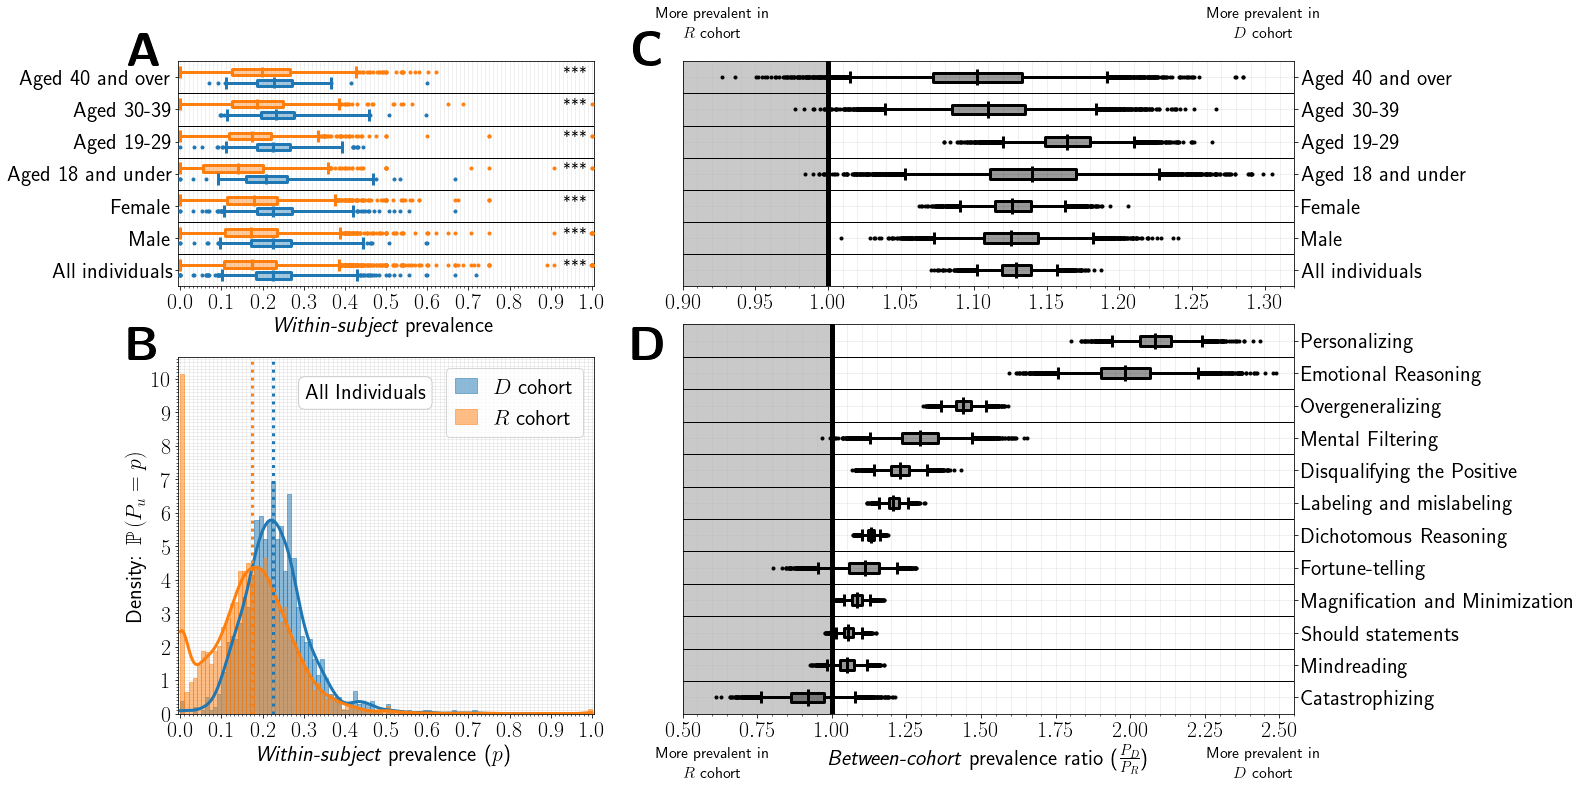

In [15]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(20, 40)


ax = fig.add_subplot(gs[9:, :15])

ax.bar(hist_bins[:-1], hist_D, color="C0", edgecolor="C0", width=0.01, lw=1, align="edge", alpha=0.5,
       label="$D$ cohort", zorder=2)
ax.bar(hist_bins[:-1], hist_R, color="C1", edgecolor="C1", width=0.01, lw=1, align="edge", alpha=0.5,
       label="$R$ cohort", zorder=2)

ax.plot(kde_bins, fit_D, color="C0", zorder=3)
ax.plot(kde_bins, fit_R, color="C1", zorder=3)

miny, maxy = ax.get_ylim()
ax.vlines(CDS_D.loc[all_D, "prevalence"].median(), 0, maxy, color="C0", linestyle=":", zorder=4)
ax.vlines(CDS_R.loc[all_R, "prevalence"].median(), 0, maxy, color="C1", linestyle=":", zorder=4)

ax.annotate(r"All Individuals", (0.45, 0.9),
            xycoords="axes fraction", ha="center", va="center", fontsize=22,
            bbox=dict(boxstyle="round", pad=0.3, fc="w", ec="0.8"))

ax.legend(ncol=1, loc="upper right")

ax.set_xlabel(r"\textit{Within-subject} prevalence ($p$)")
ax.set_xlim(-0.005, 1.005)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.01))
ax.set_ylabel(r"Density: $\mathbb{P}\left(P_u=p\right)$")
ax.set_ylim(bottom=0, top=maxy)
ax.yaxis.set_major_locator(mticker.MultipleLocator())
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))

ax = fig.add_subplot(gs[:7, :15])

ax = boxplot(ax, CDS_D.loc[all_D, "prevalence"], 0.5, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[all_R, "prevalence"], 1, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[all_D, "prevalence"], CDS_R.loc[all_R, "prevalence"], 0)

ax = boxplot(ax, CDS_D.loc[men_D, "prevalence"], 2, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[men_R, "prevalence"], 2.5, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[men_D, "prevalence"], CDS_R.loc[men_R, "prevalence"], 1.5)

ax = boxplot(ax, CDS_D.loc[women_D, "prevalence"], 3.5, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[women_R, "prevalence"], 4, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[women_D, "prevalence"], CDS_R.loc[women_R, "prevalence"], 3)

ax = boxplot(ax, CDS_D.loc[teens_D, "prevalence"], 5, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[teens_R, "prevalence"], 5.5, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[teens_D, "prevalence"], CDS_R.loc[teens_R, "prevalence"], 4.5)

ax = boxplot(ax, CDS_D.loc[twenties_D, "prevalence"], 6.5, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[twenties_R, "prevalence"], 7, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[twenties_D, "prevalence"], CDS_R.loc[twenties_R, "prevalence"], 6)

ax = boxplot(ax, CDS_D.loc[thirties_D, "prevalence"], 8, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[thirties_R, "prevalence"], 8.5, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[thirties_D, "prevalence"], CDS_R.loc[thirties_R, "prevalence"], 7.5)

ax = boxplot(ax, CDS_D.loc[adults_D, "prevalence"], 9.5, color=tab10[0])
ax = boxplot(ax, CDS_R.loc[adults_R, "prevalence"], 10, color=tab10[1])
ax = annotate_stats(ax, CDS_D.loc[adults_D, "prevalence"], CDS_R.loc[adults_R, "prevalence"], 9)

ax.hlines([1.5, 3, 4.5, 6, 7.5, 9], -0.1, 1.1, color="k", lw=1)

ax.set_xlim(-0.005, 1.005)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.01))
ax.set_ylim(bottom=0, top=10.5)
ax.set_yticks([0.75, 2.25, 3.75, 5.25, 6.75, 8.25, 9.75])
ax.set_yticklabels([r"All individuals", r"Male", r"Female", r"Aged 18 and under", 
                    r"Aged 19-29", r"Aged 30-39", r"Aged 40 and over"])
ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.grid(axis="y", which="major", b=False)
ax.set_xlabel(r"\textit{Within-subject} prevalence")

ax = fig.add_subplot(gs[8:, 18:])

for num, cat in enumerate(sorted_cats):
    ax = boxplot(ax, RP_category.loc[:, cat], num + 1, color=(0, 0, 0))

ax.fill_between([0.5, 1], sorted_cats.size + 1, color='0.7', alpha=0.7, zorder=2)
ax.vlines(1, 0, sorted_cats.size + 1, color='k', lw=5, zorder=2)
ax.hlines(np.arange(1.5, sorted_cats.size + 1), 0, 3, color="k", lw=1, zorder=2)

ax.set_xlim(left=0.5, right=2.55)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.set_xlabel(r"\textit{Between-cohort} prevalence ratio ($\frac{P_D}{P_R}$)")
ax.set_ylim(bottom=0.5, top=sorted_cats.size + 0.5)
ax.set_yticks(np.arange(1, sorted_cats.size + 1))
ax.set_yticklabels([""] + sorted_cats.values)

ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.annotate(r"\begin{center}\noindent More prevalent in\\$R$ cohort\end{center}", (0.05, -0.125),
            xycoords="axes fraction", fontsize=16, va="center", ha="center")
ax.annotate(r"\begin{center}\noindent More prevalent in\\$D$ cohort\end{center}", (0.95, -0.125),
            xycoords="axes fraction", fontsize=16, va="center", ha="center")

ax = fig.add_subplot(gs[:7, 18:])

ax = boxplot(ax, all_individuals, 1)

ax = boxplot(ax, men, 2)
ax = boxplot(ax, women, 3)

ax = boxplot(ax, teens, 4)
ax = boxplot(ax, twenties, 5)
ax = boxplot(ax, thirties, 6)
ax = boxplot(ax, adults, 7)

ax.fill_between([0.9, 1], 8, color='0.7', alpha=0.7, zorder=2)
ax.vlines(1, 0, 8, color='k', lw=5, zorder=2)
ax.hlines([1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 0, 2, color="k", lw=1, zorder=2)

ax.set_xlim(left=0.9, right=1.32)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.01))
ax.set_ylim(bottom=0.5, top=7.5)
ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels([r"All individuals", r"Male", r"Female", r"Aged 18 and under", 
                    r"Aged 19-29", r"Aged 30-39", r"Aged 40 and over"])
ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.annotate(r"\begin{center}\noindent More prevalent in\\$R$ cohort\end{center}", (0.05, 1.175),
            xycoords="axes fraction", fontsize=16, va="center", ha="center")
ax.annotate(r"\begin{center}\noindent More prevalent in\\$D$ cohort\end{center}", (0.95, 1.175),
            xycoords="axes fraction", fontsize=16, va="center", ha="center")

fig.text(0.09, 0.875, r"\textbf{A}", fontsize=48, zorder=6)
fig.text(0.09, 0.535, r"\textbf{B}", fontsize=48, zorder=6)
fig.text(0.44, 0.875, r"\textbf{C}", fontsize=48, zorder=6)
fig.text(0.44, 0.535, r"\textbf{D}", fontsize=48, zorder=6)

fig.savefig("figures/Fig2.pdf", dpi=600, orientation='portrait',
            facecolor='w', edgecolor='w', bbox_inches='tight')